In [2]:
%load_ext autoreload
%autoreload 2
import os
import os.path as osp
import numpy as np
import json
import sys
import pyvista as pv
sys.path.append('/home/tau/emenier/workspace/github_AirfRANS/')
from dataset import Dataset
import torch_geometric
import metrics
import metrics_NACA
from tqdm import tqdm
import sklearn.cluster
import matplotlib.pyplot as plt
import random
import pymetis as metis
import networkx
#import torch_geometric.nn as nng
#from torch_geometric.loader import DataLoader
#import matplotlib.pyplot as plt
#import seaborn as sns
#import h5py
#import torch
from data_utils import *
data_dir = '/home/tau/emenier/data/AirfRANS/Dataset/'

In [3]:
lst = os.listdir(data_dir)
lst = [n for n in lst if osp.isdir(osp.join(data_dir,n))]

In [4]:
j = 0
Uinf, angle = float(lst[j].split('_')[2]), float(lst[j].split('_')[3])
intern = pv.read(osp.join(data_dir, lst[j], lst[j] + '_internal.vtu'))
aerofoil = pv.read(osp.join(data_dir, lst[j], lst[j] + '_aerofoil.vtp'))
coords = intern.points

In [5]:
import scipy.spatial

In [6]:
coords = np.array(intern.points[:,:2])
tri = scipy.spatial.Delaunay(coords)

In [7]:
edges = set()
for triangle in tri.simplices:
    edge = sorted([triangle[0], triangle[1]])
    edges.add((edge[0], edge[1]))
    edge = sorted([triangle[0], triangle[2]])
    edges.add((edge[0], edge[1]))
    edge = sorted([triangle[1], triangle[2]])
    edges.add((edge[0], edge[1])) 

In [8]:
graph = networkx.Graph(list(edges)) 

In [14]:
i = 0
counts = np.array([501])
while counts.max()>500:
    edgecuts,parts = metis.part_graph( int(len(coords)/(500*(0.99-i))),graph)
    counts = np.array([(parts==i).sum() for i in np.unique(parts)])
    print(i)
    i+=0.01
print(i)
tag_list = np.unique(parts)
random.shuffle(tag_list)
parts = [tag_list[i] for i in parts]
len(parts)

print(counts.max(),counts.min(),counts.mean())

0
0.01
0.02
498 480 490.6381215469613


In [20]:
parts.shape

AttributeError: 'list' object has no attribute 'shape'

In [27]:
idx = np.where(parts == np.unique(parts)[0])[0]
coords[idx].shape

(491, 2)

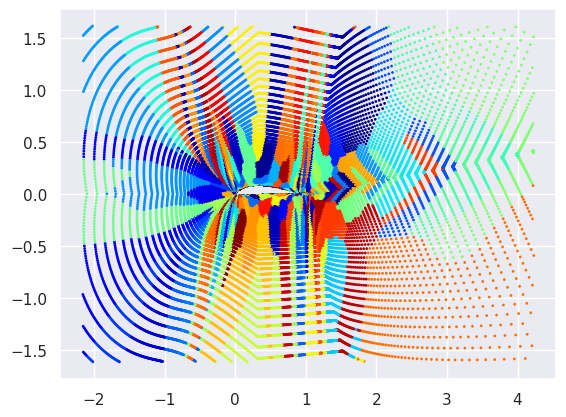

In [40]:
plt.scatter(coords[:,0],coords[:,1],c=parts,s=1,cmap=plt.cm.jet)

In [4]:
class Bag:
    def __init__(self,data,original_idx):
        self.data = data
        self.original_idx = original_idx
    
    def split(self,x_axis):
        xmin,ymin = self.data.min(0)
        xmax,ymax = self.data.max(0)
        xlims = (xmin,xmax)
        ylims = (ymin,ymax)
        mid_x = (xlims[1]+xlims[0])/2
        mid_y = (ylims[1]+ylims[0])/2
        ratio_x = (self.data[:,0]<mid_x).sum()/self.data.shape[0]
        ratio_y = (self.data[:,1]<mid_y).sum()/self.data.shape[0]
        #x_axis = abs(ratio_x-0.5)<abs(ratio_y-0.5)
        if x_axis:
            xlim1 = (xlims[0],mid_x)
            xlim2 = (mid_x,xlims[1])
            ylims = ylims
            idx1 = np.where(self.data[:,0]<mid_x)[0]
            idx2 = np.where(self.data[:,0]>=mid_x)[0]
            
        else:
            ylim1 = (ylims[0],mid_y)
            ylim2 = (mid_y,ylims[1])
            xlims = xlims
            idx1 = np.where(self.data[:,1]<mid_y)[0]
            idx2 = np.where(self.data[:,1]>=mid_y)[0]
            
        return (Bag(self.data[idx1],self.original_idx[idx1]),
               Bag(self.data[idx2],self.original_idx[idx2]))
    
def create_bags(bag,max_nmbr,x_axis):
    if bag.data.shape[0]<max_nmbr:
        return [bag]
    else:
        x_axis = not x_axis
        bag1,bag2 = bag.split(x_axis)
        return *create_bags(bag1,max_nmbr,x_axis), *create_bags(bag2,max_nmbr,x_axis)

In [5]:
coords = intern.points
idx = (coords[:,0]>-0.5) *  (coords[:,0]<1.5) * (coords[:,1]<1) * (coords[:,1]>-.5)
coords = coords[idx]
vals = intern.point_data['U'][idx,:2]
idx.sum(),coords.shape

(154960, (154960, 3))

542 0.0 541.0
[285.90405904   2.        ] -- [499   2]


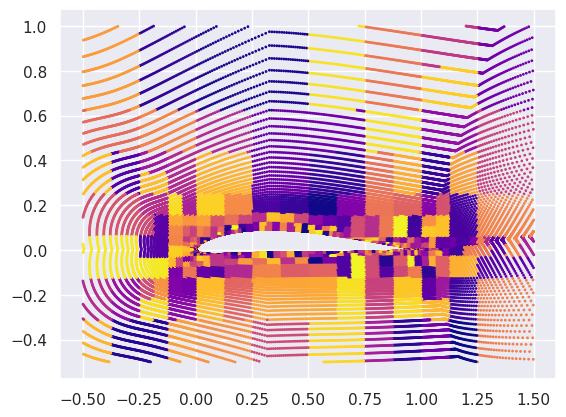

In [6]:
n_pts = coords.shape[0]
ret = create_bags(Bag(coords[:n_pts,:2],np.arange(coords.shape[0])),500,False)
ret = list(ret)
random.shuffle(ret)
colors = np.ones(n_pts)
for i,r in enumerate(ret):
    colors[r.original_idx]=i
print(len(ret),colors.min(),colors.max())
shapes = np.stack([np.array(r.data.shape) for r in ret])
print(shapes.mean(0),'--',shapes.max(0))
plt.scatter(coords[:n_pts,0],coords[:n_pts,1],s=1,c=colors,cmap=plt.cm.plasma)
#plt.ylim(-0.2,0.2); plt.xlim(-0.25,0.5)

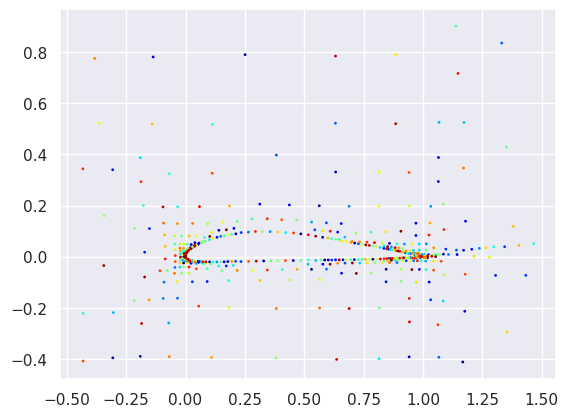

In [7]:
binned_mesh = np.stack([np.mean(r.data,0) for r in ret])
plt.scatter(binned_mesh[:,0],binned_mesh[:,1],s=1,c=np.arange(len(binned_mesh)),cmap=plt.cm.jet)

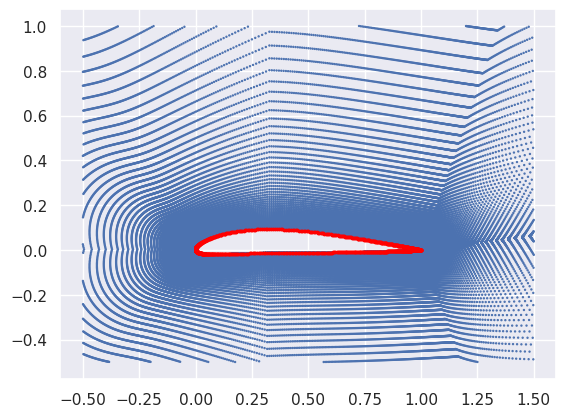

In [27]:
uvals = np.linalg.norm(vals[:,:2],axis=-1)
idx_0 = uvals<1e-6
plt.scatter(*coords.T)
plt.scatter(coords[idx_0,0],coords[idx_0,1],s=3,color='red')

In [20]:
np.stack([(uvals<1e-6) for _ in range(2)]).T.shape

(177611, 2)

In [203]:
def parse_one_case(data_dir,name,pts_per_bag):
    Uinf, angle = float(name.split('_')[2]), float(name.split('_')[3])
    intern = pv.read(osp.join(data_dir, lst[j], lst[j] + '_internal.vtu'))
    coords = intern.points
    idx = (coords[:,0]>-0.5) *  (coords[:,0]<1) * (coords[:,1]<1) * (coords[:,1]>-.5)
    coords = intern.points[idx,:2]
    values = intern.point_data['U'][idx,:2]
    bags = create_bags(Bag(coords[:n_pts,:2],np.arange(coords.shape[0])),pts_per_bag,False)
    patches_in = []
    patches_out = []
    mask = []
    for b in bags:
        flat_in = b.data.reshape(-1)
        flat_out = values[b.original_idx].reshape(-1)
        
        patches_in.append(
            np.concatenate([flat_in,np.zeros(pts_per_bag*coords.shape[-1]-len(flat_in))])
            )
        patches_out.append(
            np.concatenate([flat_out,np.zeros(pts_per_bag*values.shape[-1]-len(flat_in))])
            )
        
        mask.append((np.arange(len(patches_out[-1]))<len(flat_out)))
    return np.stack(patches_in), np.stack(patches_out), np.stack(mask), Uinf, angle
    

In [214]:
#outfile = 'pointcloud.h5'
patches_in, patches_out, mask, u, alpha= parse_one_case(data_dir,lst[0],500)

In [217]:
def to_point_cloud(mask,patches,C=2):
    mask = mask.reshape(mask.shape[0],-1,2)
    mask = mask.reshape(-1,mask.shape[-1])
    patches = patches.reshape(patches.shape[0],-1,2)
    patches = patches.reshape(-1,patches.shape[-1])
    patches = patches[mask[:,0]]
    return patches

NameError: name 'data_dir' is not defined

In [144]:
n_max,n_min =-1,np.inf 
for i in range(int(colors.max())):
    n_max = max((colors==i).sum(),n_max)
    n_min = min((colors==i).sum(),n_min)
n_max, n_min

(499, 50)

In [52]:
(clusters.labels_==9).sum()

203

In [ ]:
patches_in = torch.stack([torch.tensor(intern.points[])])

In [23]:
clusters = sklearn.cluster.KMeans(n_clusters=intern.points.shape[0]//500,
                       n_init='auto').fit(intern.points[:,:2])

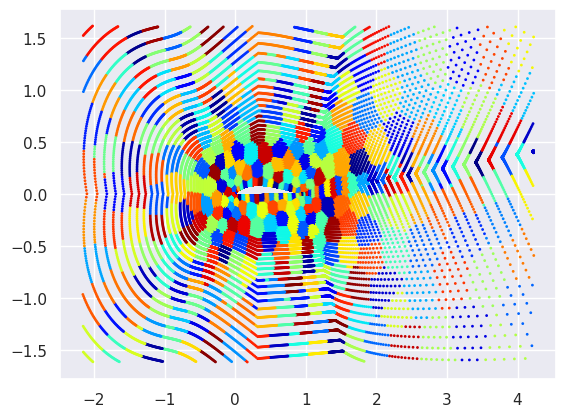

In [29]:
plt.scatter(intern.points[:,0],intern.points[:,1],s=1,c=clusters.labels_,cmap=plt.cm.jet)
#plt.ylim(-1,1); plt.xlim(-0.5,1)